In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Plotting matrix from: /content/drive/MyDrive/newProjetoMeco/BB08RE11-210-PRCMIG/BB08RE11-210-PRCMIG.npy
(2326, 23777)


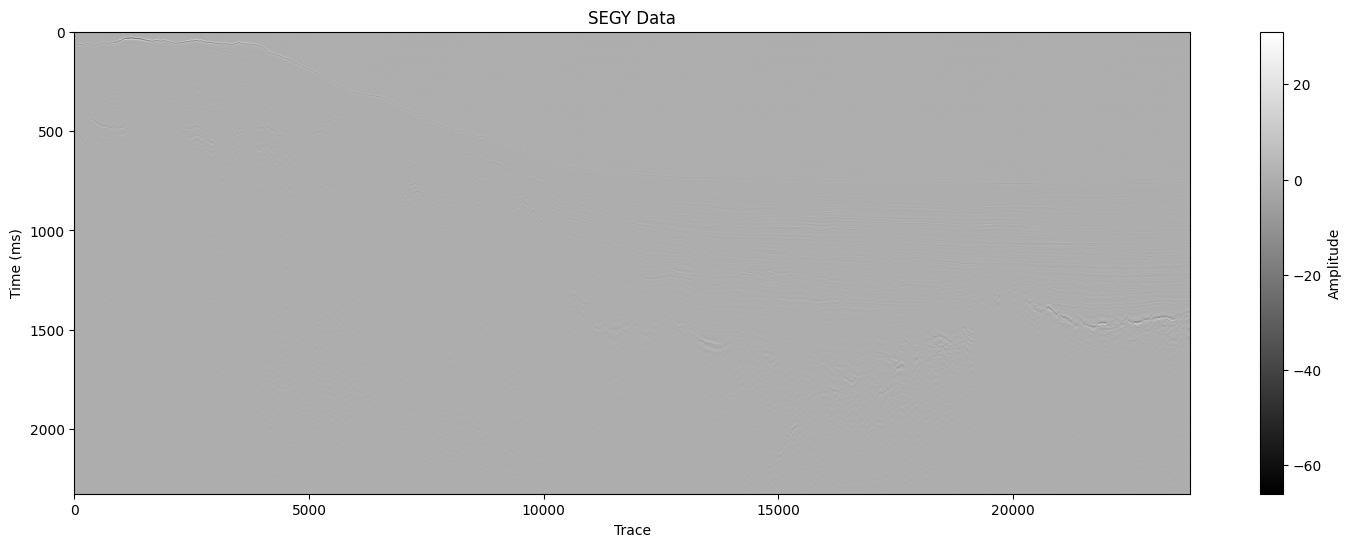

In [ ]:
def plot_numpy_matrix(npy_file, time_scale_factor=1):
    """
    Plots the numpy matrix as an image.
    """
    data = np.load(npy_file)
    num_samples, num_traces = data.shape
    print(data.shape)


    # Definindo o fator de escala para o eixo y (tempo)
    time_scale = np.arange(num_samples) * time_scale_factor

    plt.figure(figsize=figsize)
    plt.imshow(data, cmap='gray', aspect='auto', extent=[0, num_traces, time_scale[-1], time_scale[0]])
    plt.colorbar(label='Amplitude')
    plt.xlabel('Trace')
    plt.ylabel('Time (ms)')
    plt.title('SEGY Data')
    plt.show()

def plot_numpy_matrices_in_folder(folder, time_scale_factor=1):
    """
    Plots numpy matrices in the given folder.
    """
    for file in os.listdir(folder):
        if file.endswith('.npy'):
            npy_file = os.path.join(folder, file)
            print("Plotting matrix from:", npy_file)
            plot_numpy_matrix(npy_file, time_scale_factor)

# Substitua 'caminho_da_sua_pasta' pelo caminho da pasta que contém os arquivos numpy
folder_path = '/content/drive/MyDrive/newProjetoMeco/BB08RE11-210-PRCMIG/'
# Fator de escala de tempo duplo (por exemplo, 2 para escala de tempo duplo)
figsize = (18, 6)
time_scale_factor = 1
plot_numpy_matrices_in_folder(folder_path, time_scale_factor)



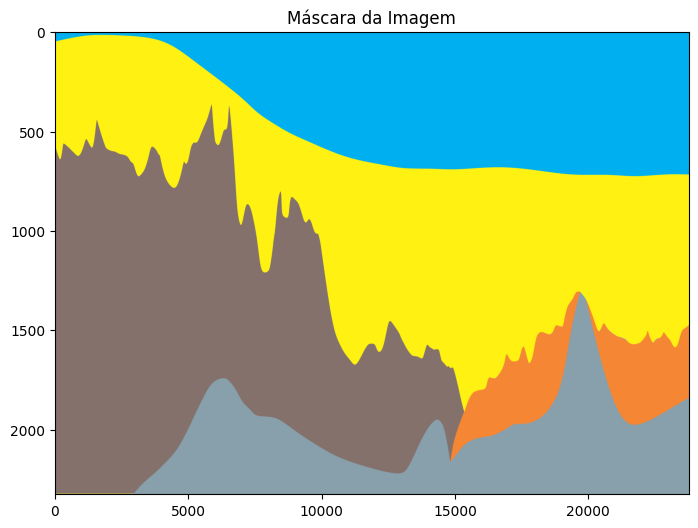

In [ ]:
imageMascara = '/content/drive/MyDrive/newProjetoMeco/BB08RE11-210-PRCMIG/Mascara_210_4.png'
# legenda = '/content/drive/MyDrive/newProjetoMeco/legenda.png'

# Ler a imagem com três canais
imgMascara = cv2.imread(imageMascara)
# legenda = cv2.imread(legenda)
imgMascara = cv2.cvtColor(imgMascara, cv2.COLOR_BGR2RGB)
# Verificar se as imagens foram carregadas corretamente
if imgMascara is None:
    print("Erro ao carregar uma ou ambas as imagens!")
else:
    # Mostrar as imagens lidas
    plt.figure(figsize=(18, 6))  # Configura o tamanho total da figura
    plt.subplot(1, 2, 1)
    plt.imshow(imgMascara, aspect='auto')
    plt.title('Máscara da Imagem')

    # plt.subplot(1, 2, 2)
    # plt.imshow(cv2.cvtColor(legenda, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()

In [ ]:
print(imgMascara.shape)

(2326, 23777, 3)


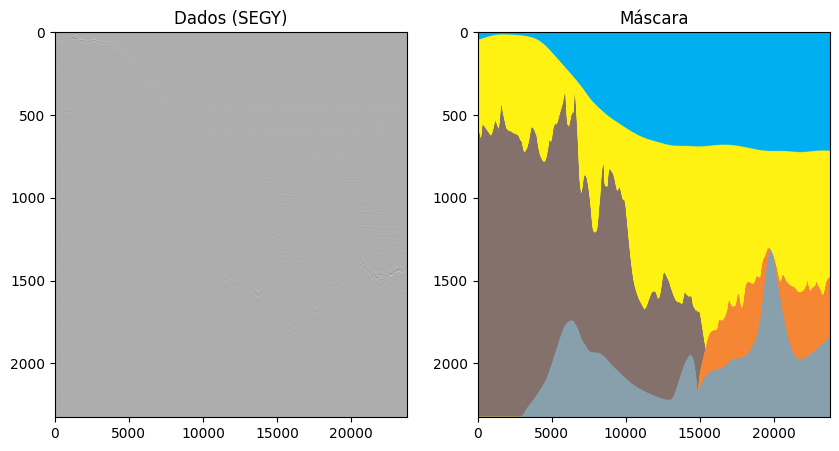

In [ ]:
import matplotlib.pyplot as plt

data = np.load('/content/drive/MyDrive/newProjetoMeco/BB08RE11-210-PRCMIG/BB08RE11-210-PRCMIG.npy')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='gray', aspect='auto')
plt.title('Dados (SEGY)')

plt.subplot(1, 2, 2)
plt.imshow(imgMascara, aspect='auto')  # Mantendo a cor
plt.title('Máscara')

plt.show()

## Começar a dividir os patches com seus labels

In [ ]:
color_to_class = {
    (0, 175, 239): 'agua',  # Azul
    (255, 242, 18): 'bacia sedimentar',  # Amarelo
    (132, 113, 107): 'crosta continental',  # Marrom
    (245, 134, 52): 'crosta oceanica',  # Laranja
    (136, 160, 172): 'manto'  # Cinza
}

In [ ]:
import numpy as np

# Definições
patch_size = (64, 64)  # Tamanho do patch
num_patches = 500  # Quantidade de patches desejada
height, width, _ = imgMascara.shape

# Função para encontrar a classe predominante em um patch
def get_dominant_class(patch, color_to_class):
    reshaped_patch = patch.reshape(-1, 3)  # Reformata para facilitar a contagem de cores
    unique_colors, counts = np.unique(reshaped_patch, axis=0, return_counts=True)
    dominant_color = unique_colors[np.argmax(counts)]
    return color_to_class.get(tuple(dominant_color), 'unknown')

# # Dividir a máscara em patches e rotular
# patch_labels = []
# for i in range(0, height, patch_size[0]):
#     for j in range(0, width, patch_size[1]):
#         # Extrair o patch
#         patch = imgMascara[i:i+patch_size[0], j:j+patch_size[1], :]

#         # Determinar a classe predominante
#         label = get_dominant_class(patch, color_to_class)
#         patch_labels.append(label)

# # Verificar os rótulos obtidos
# print("Total de patches:", len(patch_labels))
# print("Classes encontradas:", set(patch_labels))

## fazer o mesmo passo para a imagem original

In [ ]:
import numpy as np
from collections import defaultdict

# Definições
patch_size = (64, 64)  # Tamanho do patch
target_patches_per_class = 8000  # Número desejado de patches por classe
height, width, _ = imgMascara.shape

# Função para encontrar a classe predominante em um patch
def get_dominant_class(patch, color_to_class):
    reshaped_patch = patch.reshape(-1, 3)  # Reformata para facilitar a contagem de cores
    unique_colors, counts = np.unique(reshaped_patch, axis=0, return_counts=True)
    dominant_color = unique_colors[np.argmax(counts)]
    return color_to_class.get(tuple(dominant_color), 'unknown')  # Retorna 'unknown' se a cor não for reconhecida

# Carregar a imagem
image_npy_path = '/content/drive/MyDrive/newProjetoMeco/BB08RE11-210-PRCMIG/BB08RE11-210-PRCMIG.npy'
image_data = np.load(image_npy_path)

# Ajustar os tamanhos para evitar problemas com patches fora da imagem
adjusted_height = height - patch_size[0]
adjusted_width = width - patch_size[1]

# Listas para armazenar patches
image_patches = []
mask_patches = []
patch_labels = []

# Dicionário para contar os patches por classe
class_counts = defaultdict(int)

# Enquanto não atingirmos 4.000 patches por classe
while any(count < target_patches_per_class for count in class_counts.values()) or len(class_counts) < 5:
    # Escolher um ponto de origem aleatório garantindo que o patch caiba dentro da imagem
    i = np.random.randint(0, adjusted_height)
    j = np.random.randint(0, adjusted_width)

    # Extrair patches da imagem e da máscara
    image_patch = image_data[i:i+patch_size[0], j:j+patch_size[1]]
    mask_patch = imgMascara[i:i+patch_size[0], j:j+patch_size[1], :]

    # Determinar a classe do patch com base na máscara
    label = get_dominant_class(mask_patch, color_to_class)

    # Adicionar apenas se a classe ainda não atingiu o limite
    if class_counts[label] < target_patches_per_class:
        image_patches.append(image_patch)
        mask_patches.append(mask_patch)
        patch_labels.append(label)
        class_counts[label] += 1

In [ ]:
import numpy as np
import os

# Diretório para salvar os arquivos
output_dir = "/content/drive/MyDrive/newProjetoMeco/patches/"
os.makedirs(output_dir, exist_ok=True)

# Salvar os patches de imagem (já são np.array)
np.save(os.path.join(output_dir, "image_patches.npy"), np.array(image_patches, dtype=np.float32))

# Salvar os patches de máscara (garantindo uint8 para manter as cores)
np.save(os.path.join(output_dir, "mask_patches.npy"), np.array(mask_patches, dtype=np.uint8))

print("Arquivos salvos com sucesso!")


Arquivos salvos com sucesso!


In [ ]:
# Verificar se conseguimos atingir 4.000 patches por classe
print("Total de patches gerados:", len(image_patches))
for class_name, count in class_counts.items():
    print(f"Classe '{class_name}': {count} patches")

Total de patches gerados: 20000
Classe 'bacia sedimentar': 4000 patches
Classe 'agua': 4000 patches
Classe 'crosta continental': 4000 patches
Classe 'manto': 4000 patches
Classe 'crosta oceanica': 4000 patches


## verificando se deu tudo certo graficamente

In [ ]:
from collections import Counter

# Contar a frequência de cada classe
class_counts = Counter(patch_labels)

# Exibir a contagem das classes
for class_name, count in class_counts.items():
    print(f"Classe '{class_name}': {count} patches")

Classe 'bacia sedimentar': 4000 patches
Classe 'agua': 4000 patches
Classe 'crosta continental': 4000 patches
Classe 'manto': 4000 patches
Classe 'crosta oceanica': 4000 patches


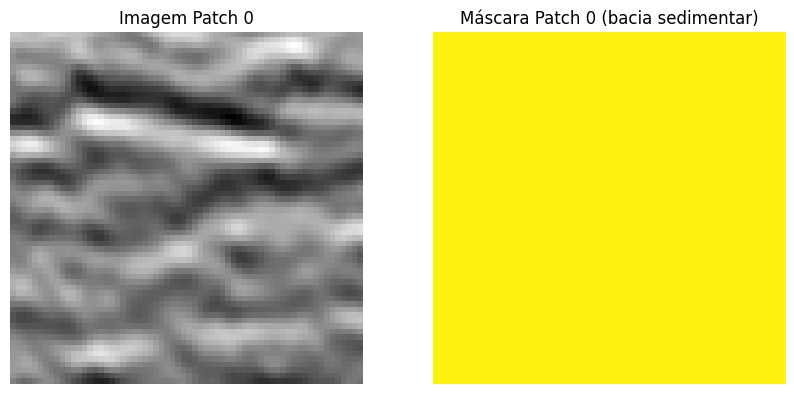

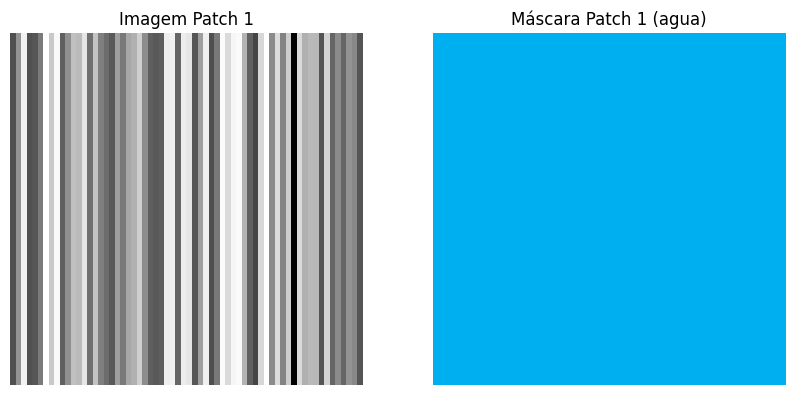

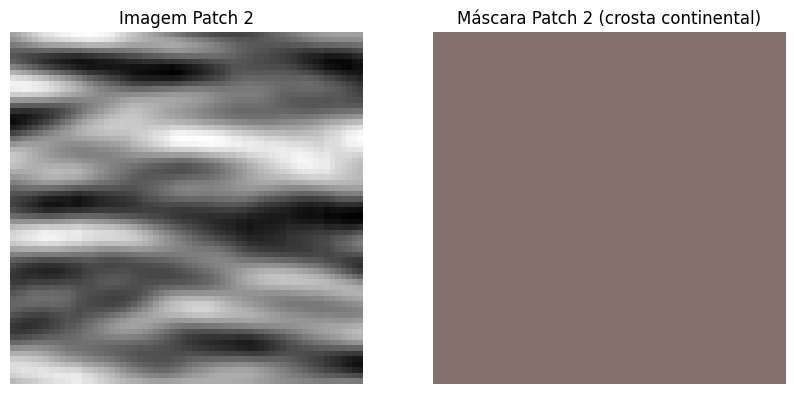

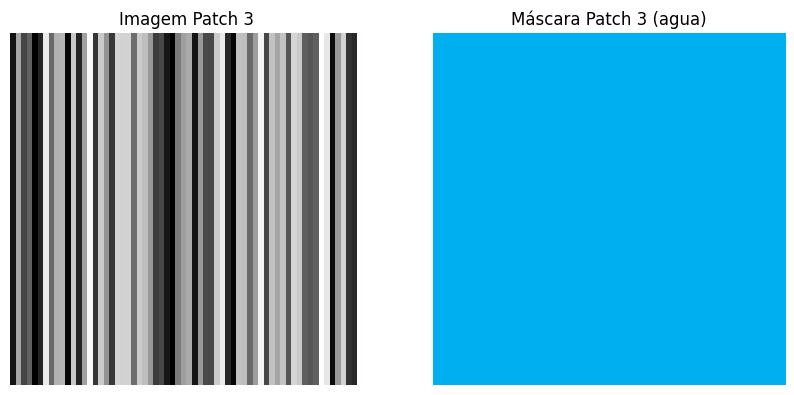

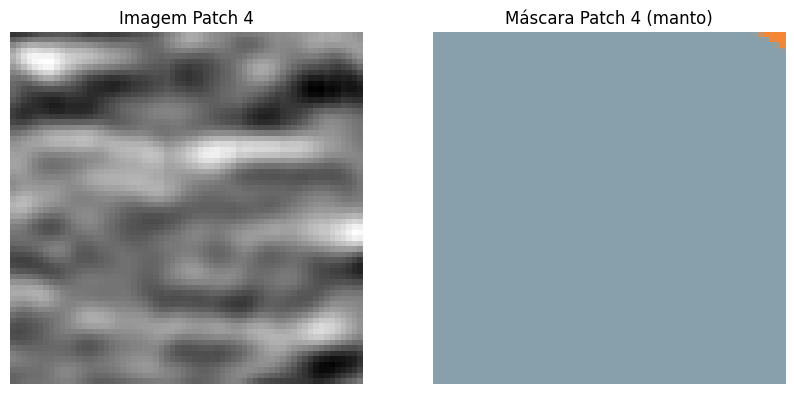

In [ ]:
import matplotlib.pyplot as plt

# Função para exibir um patch da imagem e da máscara com seu rótulo
def display_patch(image_patch, mask_patch, label, patch_idx):
    plt.figure(figsize=(10, 5))

    # Patch da imagem
    plt.subplot(1, 2, 1)
    plt.imshow(image_patch, cmap='gray')  # Ajuste o cmap se necessário
    plt.title(f"Imagem Patch {patch_idx}")
    plt.axis('off')

    # Patch da máscara
    plt.subplot(1, 2, 2)
    plt.imshow(mask_patch)
    plt.title(f"Máscara Patch {patch_idx} ({label})")
    plt.axis('off')

    plt.show()

# Testar visualizando alguns patches
for idx in range(0,5):  # Altere o número de patches a exibir
    display_patch(image_patches[idx], mask_patches[idx], patch_labels[idx], idx)

# Não é preciso usar Data Augmentation com patches aleatorios

In [ ]:
# # Data augmentation
# from collections import Counter
# from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate
# from albumentations.core.composition import OneOf
# import random

# # Data augmentation
# augmentation = Compose([
#     OneOf([
#         HorizontalFlip(p=0.5),
#         VerticalFlip(p=0.5),
#     ], p=0.5),
#     Rotate(limit=45, p=0.5),
# ])

# # Balancear classes
# balanced_patches = []
# balanced_labels = []

# # Quantidade alvo de patches por classe
# target_patches = 4000  # Número máximo de patches desejado por classe

# # Iterar por cada classe e balancear
# for class_name in class_counts:
#     class_indices = [idx for idx, label in enumerate(patch_labels) if label == class_name]
#     current_patches = [image_patches[idx] for idx in class_indices]

#     # Adicionar patches existentes
#     balanced_patches.extend(current_patches)
#     balanced_labels.extend([class_name] * len(current_patches))

#     # Gerar patches adicionais para balancear, se necessário
#     while len(current_patches) < target_patches:
#         for patch in current_patches:
#             augmented = augmentation(image=patch)['image']
#             balanced_patches.append(augmented)
#             balanced_labels.append(class_name)
#             current_patches.append(augmented)  # Adicionar o patch aumentado para continuar gerando até atingir a quantidade desejada
#             if len(current_patches) >= target_patches:
#                 break

# # Verificar a nova contagem de classes
# new_class_counts = Counter(balanced_labels)
# print("\nContagem balanceada de classes:")
# for class_name, count in new_class_counts.items():
#     print(f"Classe '{class_name}': {count} patches")

## iniciar o treinamento

In [ ]:
color_to_class.values()

dict_values(['agua', 'bacia sedimentar', 'crosta continental', 'crosta oceanica', 'manto'])

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convertendo os novos patches e rótulos balanceados para arrays numpy
X_balanced = np.array(image_patches)  # Novos patches balanceados
y_balanced = np.array([list(color_to_class.values()).index(label) for label in patch_labels])  # Classes como índices

# Separar treino, validação e teste (70% treino, 15% validação, 15% teste)
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de validação: {len(X_val)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

Tamanho do conjunto de treino: 14000
Tamanho do conjunto de validação: 3000
Tamanho do conjunto de teste: 3000


## dividir apenas em treino e validação. e usar a imagem toda na matriz de confusão

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # Camadas convolucionais
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten e camadas densas
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(color_to_class), activation='softmax')  # Número de classes na saída
])

# Testar diferentes valores de kernel (aumentar nas primeiras camadas)

# Compilar o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,021 (4.36 MB)

 Trainable params: 1,142,021 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

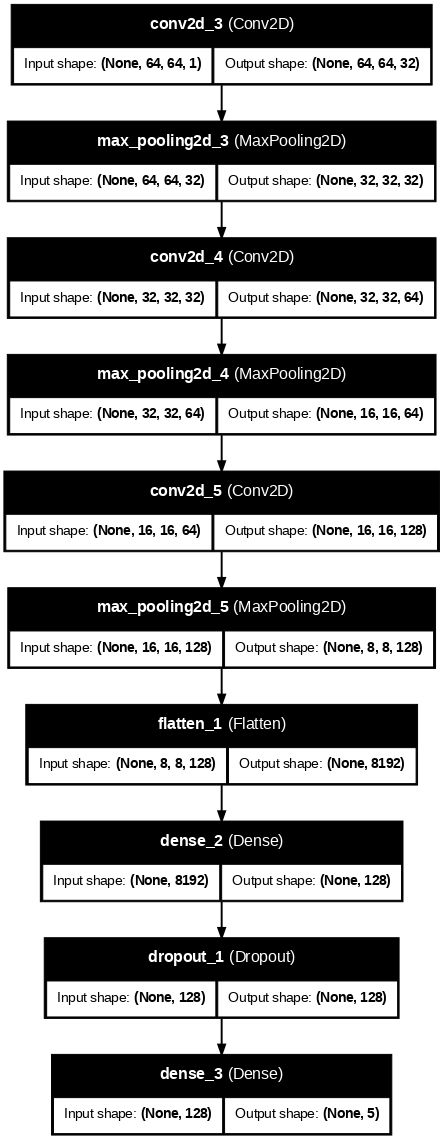

In [ ]:
from tensorflow.keras.utils import plot_model

# Gerar e salvar a imagem do modelo com menor resolução (dpi)
plot_model(model, to_file='model_architecture_small.png', show_shapes=True, show_layer_names=True, dpi=70)


## verificar as saidas de imagem da rede

In [ ]:
# Ajustar as dimensões para o canal de entrada (grayscale)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32
)

# Salvar o modelo treinado
model.save('modelo_treinado2.h5')

Epoch 1/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5853 - loss: 0.9521 - val_accuracy: 0.7557 - val_loss: 0.5634
Epoch 2/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7304 - loss: 0.6274 - val_accuracy: 0.7460 - val_loss: 0.5691
Epoch 3/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7495 - loss: 0.5651 - val_accuracy: 0.7960 - val_loss: 0.4901
Epoch 4/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7768 - loss: 0.5124 - val_accuracy: 0.7953 - val_loss: 0.4775
Epoch 5/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7894 - loss: 0.4804 - val_accuracy: 0.7540 - val_loss: 0.5413
Epoch 6/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8038 - loss: 0.4473 - val_accuracy: 0.7877 - val_loss: 0.4893
Epoch 7/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8228 - loss: 0.4201 - val_accuracy: 0.7937 - val_loss: 0.4785
Epoch 8/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8409 - loss: 0.3728 - val_accuracy: 0

In [ ]:
# Avaliar no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Perda no teste: {test_loss:.4f}")
print(f"Acurácia no teste: {test_accuracy:.4f}")

94/94 - 0s - 3ms/step - accuracy: 0.8017 - loss: 1.1384
Perda no teste: 1.1384
Acurácia no teste: 0.8017


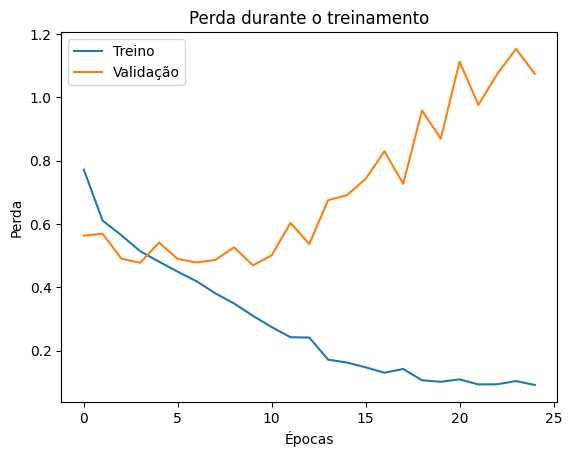

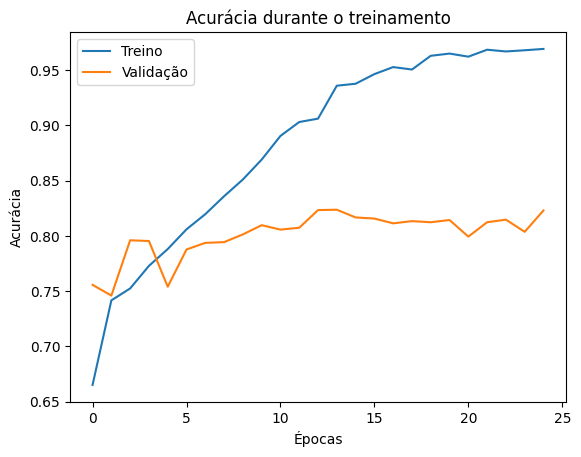

In [ ]:
import matplotlib.pyplot as plt

# Perda
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Acurácia
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
                    precision    recall  f1-score   support

              agua       0.98      1.00      0.99       600
  bacia sedimentar       0.95      0.88      0.91       600
crosta continental       0.66      0.54      0.59       600
   crosta oceanica       0.78      0.85      0.81       600
             manto       0.65      0.74      0.69       600

          accuracy                           0.80      3000
         macro avg       0.80      0.80      0.80      3000
      weighted avg       0.80      0.80      0.80      3000



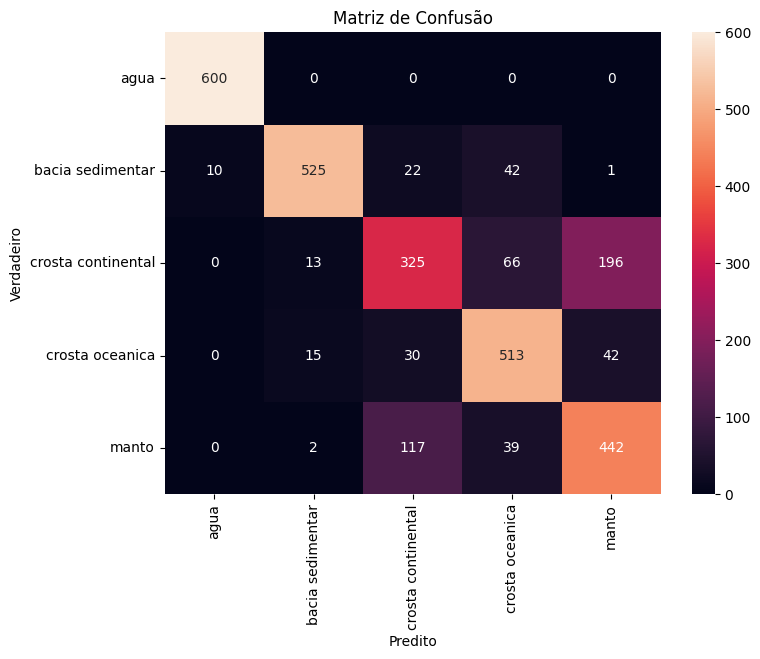

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predições no conjunto de teste
y_pred = np.argmax(model.predict(X_test), axis=1)

# Relatório de classificação
print(classification_report(y_test, y_pred, target_names=color_to_class.values()))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=color_to_class.values(), yticklabels=color_to_class.values())
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

## Exemplificação

In [ ]:
import random

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


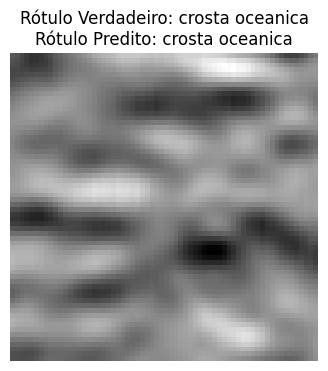

In [ ]:
# Atualize o mapeamento para refletir corretamente a correspondência entre o índice e a classe
index_to_class = {0: 'agua', 1: 'bacia sedimentar', 2: 'crosta continental', 3: 'crosta oceanica', 4: 'manto'}

# Seleção de um exemplo aleatório do conjunto de teste
index = random.randint(0, len(X_test) - 1)
patch = X_test[index]  # O patch da imagem
true_label = y_test[index]  # O rótulo verdadeiro
predicted_label = np.argmax(model.predict(patch[np.newaxis, ...]), axis=1)[0]  # O rótulo predito

# Obter nomes das classes
true_label_name = index_to_class.get(true_label, f"Classe desconhecida ({true_label})")
predicted_label_name = index_to_class.get(predicted_label, f"Classe desconhecida ({predicted_label})")

# Visualizar o patch e os rótulos
plt.figure(figsize=(4, 4))
plt.imshow(patch.squeeze(), cmap='gray')  # Mostrar o patch
plt.title(f"Rótulo Verdadeiro: {true_label_name}\nRótulo Predito: {predicted_label_name}")
plt.axis('off')
plt.show()

## Segmentando a imagem